# Introduction to clustering
## Preface
You might already have heard about linear regression, where we try to learn how our measurements affect a target variable (e.g. effect of culturing temperature and nutrient availability on cell growth) or classification, where the task is to learn basic discriminating properties between groups of samples to later automatically assign new samples to either group (e.g. classification of samples as tumor/non-tumor based on the samples expression profile). Such methods belong to the, so called, supervised approached in machine learning and are routinely used procedures in data analysis. 

However, more often than we would like, we are presented with a set of samples where we do not know the group assignment apriori, hence unlabeled data, but would like to infer a plausible partitioning for them. This task belongs to the unsupervised approaches and is referred to as clustering and and a prime example from our daily lives would be single cell RNA sequencing data analysis where usually don't know the type of each sequenced cell and have to somehow compute it based on the cells transcriptomic similarity. 

Loosly spoken, clustering is the procedure of infering groupings of samples based on their similarity. Similarity, however, is a quite extensive term and can be defined in many ways, like similarity based on all transcribed genes, similarity based on overlap of expressed genes in a given pair of cells, similarity based on morphology of the cells etc. and it usually depends on us to pick the right definition to find useful results. Furthermore, there are a myriad of different algorithms which are tuned towards different properties of the data we feed them (e.g. k-means assumes a gaussian distribution of samples within each cluster and thus performs best if this assumption is fulfilled while agglomerative clustering does not assume anything about the data at all).

In conclusion, our results strongly depende on the way we define similarity and the algorithm we choose for the task at hand (illustrated below). Doing this the right way is an art for its own so don't get frustrated right away ;)

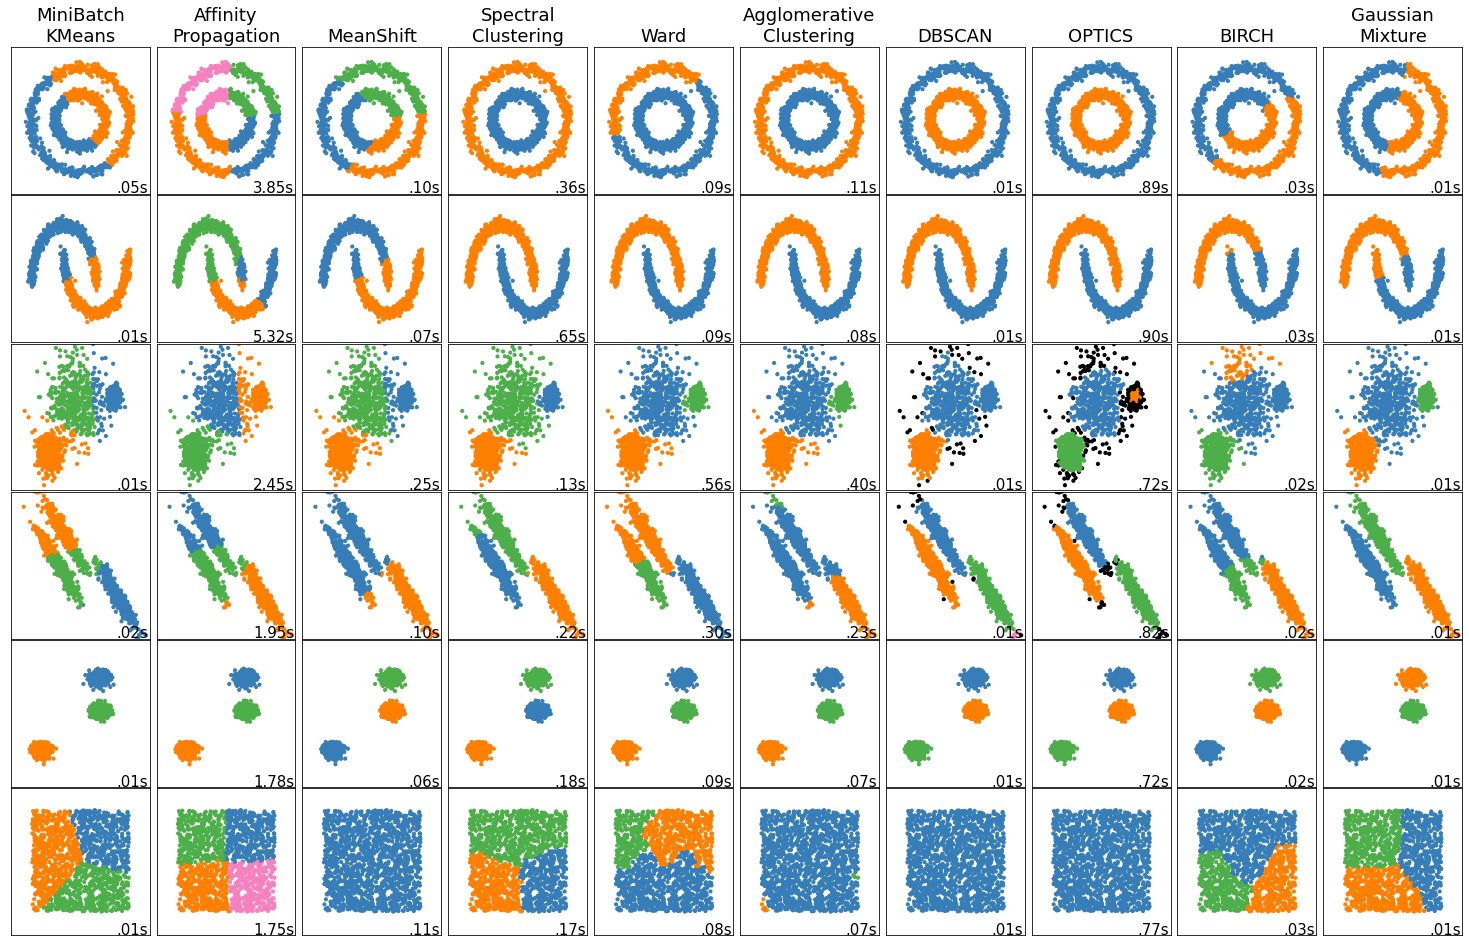

In [1]:
# taken from https://scikit-learn.org/stable/auto_examples/cluster/plot_cluster_comparison.html
import time
import warnings

import numpy as np
import matplotlib.pyplot as plt

from sklearn import cluster, datasets, mixture
from sklearn.neighbors import kneighbors_graph
from sklearn.preprocessing import StandardScaler
from itertools import cycle, islice

np.random.seed(0)

# ============
# Generate datasets. We choose the size big enough to see the scalability
# of the algorithms, but not too big to avoid too long running times
# ============
n_samples = 1500
noisy_circles = datasets.make_circles(n_samples=n_samples, factor=0.5, noise=0.05)
noisy_moons = datasets.make_moons(n_samples=n_samples, noise=0.05)
blobs = datasets.make_blobs(n_samples=n_samples, random_state=8)
no_structure = np.random.rand(n_samples, 2), None

# Anisotropicly distributed data
random_state = 170
X, y = datasets.make_blobs(n_samples=n_samples, random_state=random_state)
transformation = [[0.6, -0.6], [-0.4, 0.8]]
X_aniso = np.dot(X, transformation)
aniso = (X_aniso, y)

# blobs with varied variances
varied = datasets.make_blobs(
    n_samples=n_samples, cluster_std=[1.0, 2.5, 0.5], random_state=random_state
)

# ============
# Set up cluster parameters
# ============
plt.figure(figsize=(9 * 2 + 3, 13))
plt.subplots_adjust(
    left=0.02, right=0.98, bottom=0.001, top=0.95, wspace=0.05, hspace=0.01
)

plot_num = 1

default_base = {
    "quantile": 0.3,
    "eps": 0.3,
    "damping": 0.9,
    "preference": -200,
    "n_neighbors": 10,
    "n_clusters": 3,
    "min_samples": 20,
    "xi": 0.05,
    "min_cluster_size": 0.1,
}

datasets = [
    (
        noisy_circles,
        {
            "damping": 0.77,
            "preference": -240,
            "quantile": 0.2,
            "n_clusters": 2,
            "min_samples": 20,
            "xi": 0.25,
        },
    ),
    (noisy_moons, {"damping": 0.75, "preference": -220, "n_clusters": 2}),
    (
        varied,
        {
            "eps": 0.18,
            "n_neighbors": 2,
            "min_samples": 5,
            "xi": 0.035,
            "min_cluster_size": 0.2,
        },
    ),
    (
        aniso,
        {
            "eps": 0.15,
            "n_neighbors": 2,
            "min_samples": 20,
            "xi": 0.1,
            "min_cluster_size": 0.2,
        },
    ),
    (blobs, {}),
    (no_structure, {}),
]

for i_dataset, (dataset, algo_params) in enumerate(datasets):
    # update parameters with dataset-specific values
    params = default_base.copy()
    params.update(algo_params)

    X, y = dataset

    # normalize dataset for easier parameter selection
    X = StandardScaler().fit_transform(X)

    # estimate bandwidth for mean shift
    bandwidth = cluster.estimate_bandwidth(X, quantile=params["quantile"])

    # connectivity matrix for structured Ward
    connectivity = kneighbors_graph(
        X, n_neighbors=params["n_neighbors"], include_self=False
    )
    # make connectivity symmetric
    connectivity = 0.5 * (connectivity + connectivity.T)

    # ============
    # Create cluster objects
    # ============
    ms = cluster.MeanShift(bandwidth=bandwidth, bin_seeding=True)
    two_means = cluster.MiniBatchKMeans(n_clusters=params["n_clusters"])
    ward = cluster.AgglomerativeClustering(
        n_clusters=params["n_clusters"], linkage="ward", connectivity=connectivity
    )
    spectral = cluster.SpectralClustering(
        n_clusters=params["n_clusters"],
        eigen_solver="arpack",
        affinity="nearest_neighbors",
    )
    dbscan = cluster.DBSCAN(eps=params["eps"])
    optics = cluster.OPTICS(
        min_samples=params["min_samples"],
        xi=params["xi"],
        min_cluster_size=params["min_cluster_size"],
    )
    affinity_propagation = cluster.AffinityPropagation(
        damping=params["damping"], preference=params["preference"], random_state=0
    )
    average_linkage = cluster.AgglomerativeClustering(
        linkage="average",
        affinity="cityblock",
        n_clusters=params["n_clusters"],
        connectivity=connectivity,
    )
    birch = cluster.Birch(n_clusters=params["n_clusters"])
    gmm = mixture.GaussianMixture(
        n_components=params["n_clusters"], covariance_type="full"
    )

    clustering_algorithms = (
        ("MiniBatch\nKMeans", two_means),
        ("Affinity\nPropagation", affinity_propagation),
        ("MeanShift", ms),
        ("Spectral\nClustering", spectral),
        ("Ward", ward),
        ("Agglomerative\nClustering", average_linkage),
        ("DBSCAN", dbscan),
        ("OPTICS", optics),
        ("BIRCH", birch),
        ("Gaussian\nMixture", gmm),
    )

    for name, algorithm in clustering_algorithms:
        t0 = time.time()

        # catch warnings related to kneighbors_graph
        with warnings.catch_warnings():
            warnings.filterwarnings(
                "ignore",
                message="the number of connected components of the "
                + "connectivity matrix is [0-9]{1,2}"
                + " > 1. Completing it to avoid stopping the tree early.",
                category=UserWarning,
            )
            warnings.filterwarnings(
                "ignore",
                message="Graph is not fully connected, spectral embedding"
                + " may not work as expected.",
                category=UserWarning,
            )
            algorithm.fit(X)

        t1 = time.time()
        if hasattr(algorithm, "labels_"):
            y_pred = algorithm.labels_.astype(int)
        else:
            y_pred = algorithm.predict(X)

        plt.subplot(len(datasets), len(clustering_algorithms), plot_num)
        if i_dataset == 0:
            plt.title(name, size=18)

        colors = np.array(
            list(
                islice(
                    cycle(
                        [
                            "#377eb8",
                            "#ff7f00",
                            "#4daf4a",
                            "#f781bf",
                            "#a65628",
                            "#984ea3",
                            "#999999",
                            "#e41a1c",
                            "#dede00",
                        ]
                    ),
                    int(max(y_pred) + 1),
                )
            )
        )
        # add black color for outliers (if any)
        colors = np.append(colors, ["#000000"])
        plt.scatter(X[:, 0], X[:, 1], s=10, color=colors[y_pred])

        plt.xlim(-2.5, 2.5)
        plt.ylim(-2.5, 2.5)
        plt.xticks(())
        plt.yticks(())
        plt.text(
            0.99,
            0.01,
            ("%.2fs" % (t1 - t0)).lstrip("0"),
            transform=plt.gca().transAxes,
            size=15,
            horizontalalignment="right",
        )
        plot_num += 1

plt.show()

## The data
To illustrate some of the basic concepts of clustering we will work on a single cell RNA-seq data set and try to infer groupings (aka cell that are most similar and thus might be of the same cell type). The data was generated from mouse brain using the SMART-seq protocol and is already processed up to the point where we will try to cluster it (quality controlled, aligned, counted, TPM normalized and log-transformed, so you do not need to worry about the technical details). We will do this by first visualizing the data in a way we might already see how many cell types we are dealing with and then go on to apply some of the most commonly used algorithms to cluster the data. So let's start.

In [2]:
import pandas as pd
# reading and displaying the provided data
data = pd.read_csv(
    'data/scRNAseq_data.csv',
    index_col = 0 # this parameter tells the parser to use the first column as table index
)
data

,0610040J01Rik,1110019D14Rik,1600029O15Rik,1700003E16Rik,1700017B05Rik,2310043P16Rik,2610507I01Rik,2700046A07Rik,2810414N06Rik,2810430I11Rik,...,Zfp784,Zfp808,Zfp811,Zfp960,Zfpm1,Zfyve28,Zic3,Zic4,Znrf3,Zswim3
sample_id,,,,,,,,,,,,,,,,,,,,,
162322,0.000000,0.0,5.033924,0.0,0.000000,0.0,0.0,2.444607,0.0,0.0,...,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000
162324,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.000000,3.999308,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000
162325,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000
162326,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000
162328,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
162557,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.000000,4.314340,0.0,0.000000,0.000000,0.0,0.0,0.000000,3.807101
162559,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000
162561,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.000000,3.227231,0.0,5.099024,0.000000,0.0,0.0,3.339727,0.000000


The data is organized as a table containing the sequenced cells as rows and a subset of the quantified genes as columns. Thus, we have a ncells x ngenes data table

## Visualization
Visualizing the data before working on it has many advantages. It helps identifying any apparent patterns visually and thus helps in choosing the right algorithm and the possibly the right parameters like number of expected clusters. Therefore, we will start out by plotting the data as a scatterplot to be able to look at it. However, if you haven't noticed yet, displaying more than 3 dimensions is quite impossible. Thus, we first have to compute a low dimensional representation of the data to accomplish our desired visualization and we will do so using a simple PCA.

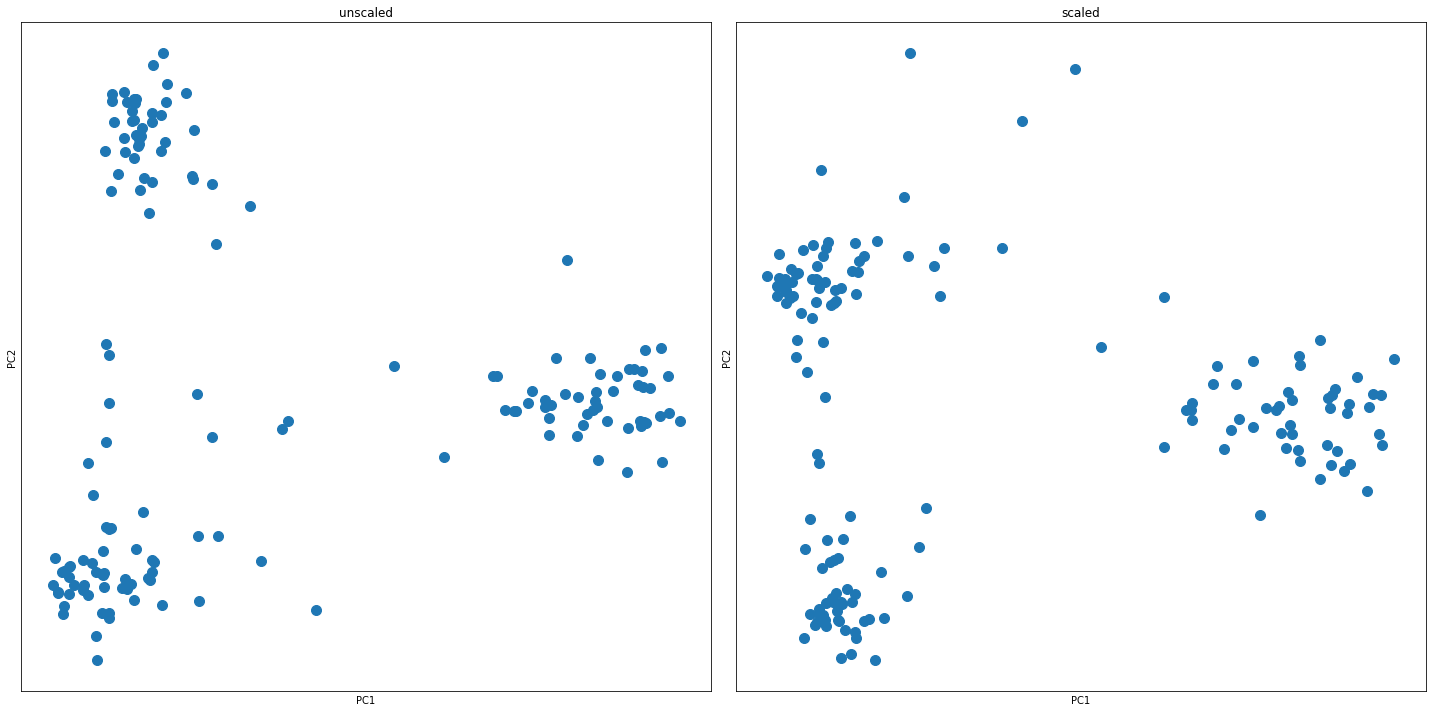

In [3]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
# setting up the PCA transformer with a desired number of components of 2
# so it fits nicely into a two dimensional figure
pca = PCA(n_components = 2)

# preparing a StandardScaler which will scale the distribution of expression
# of each gene to the standard normal distribution which sometimes aids visualization
# due to possible introduction of artifacts if variation of some features are quite small
scaler = StandardScaler(copy = True)

'''
the pca.fit_transform method essentially performs two steps in one
1. it will compute the different principal components (fit)
2. it will use the first n_components to project the data into n_component-dimensional space
in our case 2-dimensional space. pca_transform then holds the transformed data
where the first column contains the coordinates along the first PC and
the second the coordinates along the second PC
'''
pca_transform_unscaled = pca.fit_transform(
    data.values # returns a raw matrix (i.e. the table without index and column labels)
)
pca_transform_scaled = pca.fit_transform(
    scaler.fit_transform(data.values) # returns a raw matrix of scaled values (i.e. the table without index and column labels)
)

# generating figure and axes for plotting
fig, axs = plt.subplots(1, 2)

# plotting data
for ax, transform, label in zip(
    axs,
    [pca_transform_unscaled, pca_transform_scaled],
    ['unscaled', 'scaled']
):
    # generation of scatter plot using pca transformed data
    ax.scatter(
        transform[:, 0], # PC1
        transform[:, 1], # PC2
        s = 100 # setting dot size
    )
    
    # applying some cosmetics
    ax.set_xticks([]) # passing an empty list will remove ticks from the axis
    ax.set_yticks([])
    ax.set_xlabel('PC1') # setting axis label
    ax.set_ylabel('PC2')
    ax.set_title(label) # setting plot title

# setting figure size
fig.set_figwidth(20)
fig.set_figheight(10)
fig.tight_layout()

Looking at the figure above we clearly see three distinct clusters. Although there might be more clusters than we can visually distinguish we will set out to use three as the expected number of clusters. Furthermore, in this figure we also tried to compare the visualization of unscaled and scaled data. Scaling the data to standard normal distribution or similar is sometimes useful to avoid artifacts introduced by features that are very different in magnitude (e.g. very large values which will inflate variance and thus obscure the PCA or very small values which will do the opposite). However, since gene expression values were already log transformed and thus are on a very similar scale there is not much gain from scaling except some compaction of the apparent clusters. Thus, we will proceed with the unscaled data.

## Agglomerative clustering
Agglomerative clustering is a very simple but effective algorithm. In brief, it relies on distances between the individual data points to merge the two closest points into a cluster and proceeds to do so until all points are within a single cluster. The desired number of clusters can then be found by simply cutting the inferred dendrogram at a certain level where are left with n groups of points.

We are going to use the scikit-learn implementation of the algorithm and although this does not require use to precompute the pairwise distances between the data points, there are a few advantages to do so and also visualize them. Firstly, this way we already get a hint of what our output clustering will look like (squares along the diagonal will roughly correspond to cohesive groupings of the data). Secondly, visualizing the computed distance matrix makes changes of clustering based on the distance metric we choose directly observable, which comes in handy when feeling indecisive about which one to use. And lastly, not all distance metrics that are available in the scikit-learn package are available per default so if you want to use some more exotic distance metrics or even your own you have to supply the distance matrix manually.

So, let's start with computing the pairwise distances between data points and visualizing these distances as a heatmap (although the `sns.clustermap` does more than just displaying the distances. It uses a similar approach as agglomerative clustering to order the individual pairs of cells in the heatma; see also the dendorgram). 

/Users/dmalzl/miniconda3/envs/clustering/lib/python3.10/site-packages/seaborn/matrix.py:654: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
/Users/dmalzl/miniconda3/envs/clustering/lib/python3.10/site-packages/seaborn/matrix.py:624: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  linkage = hierarchy.linkage(self.array, method=self.method,


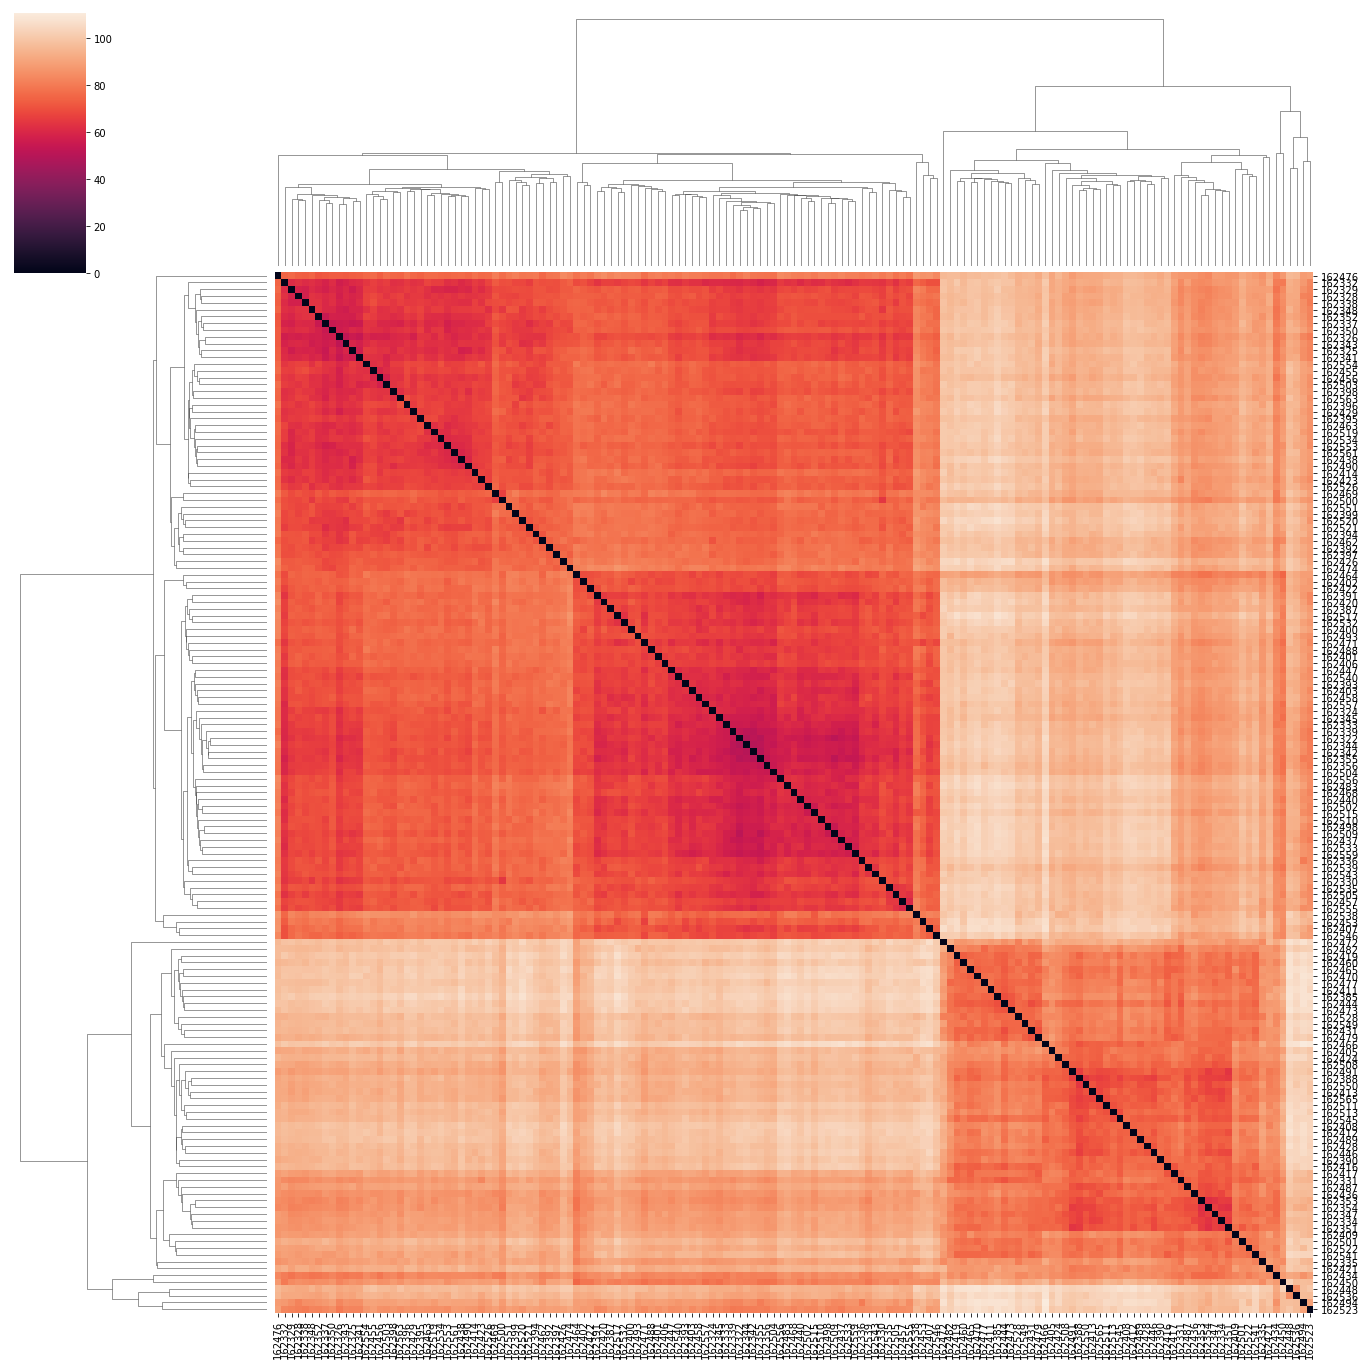

In [4]:
from sklearn.metrics import pairwise_distances
import seaborn as sns

# computing pairwise similarity defined as distance measure
# the closer two points are the more similar they are
# see https://docs.scipy.org/doc/scipy/reference/spatial.distance.html
# for all distances available
euclid_distances = pairwise_distances(
    data.values,
    metric = 'euclidean'
)
clustermap = sns.clustermap(
    euclid_distances,
    xticklabels = data.index,
    yticklabels = data.index
)
clustermap.fig.set_figheight(20)
clustermap.fig.set_figwidth(20)

Looking good already but there resolution between two clusters looks a bit faint so we might try some other distance metric

/Users/dmalzl/miniconda3/envs/clustering/lib/python3.10/site-packages/seaborn/matrix.py:654: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
/Users/dmalzl/miniconda3/envs/clustering/lib/python3.10/site-packages/seaborn/matrix.py:624: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  linkage = hierarchy.linkage(self.array, method=self.method,


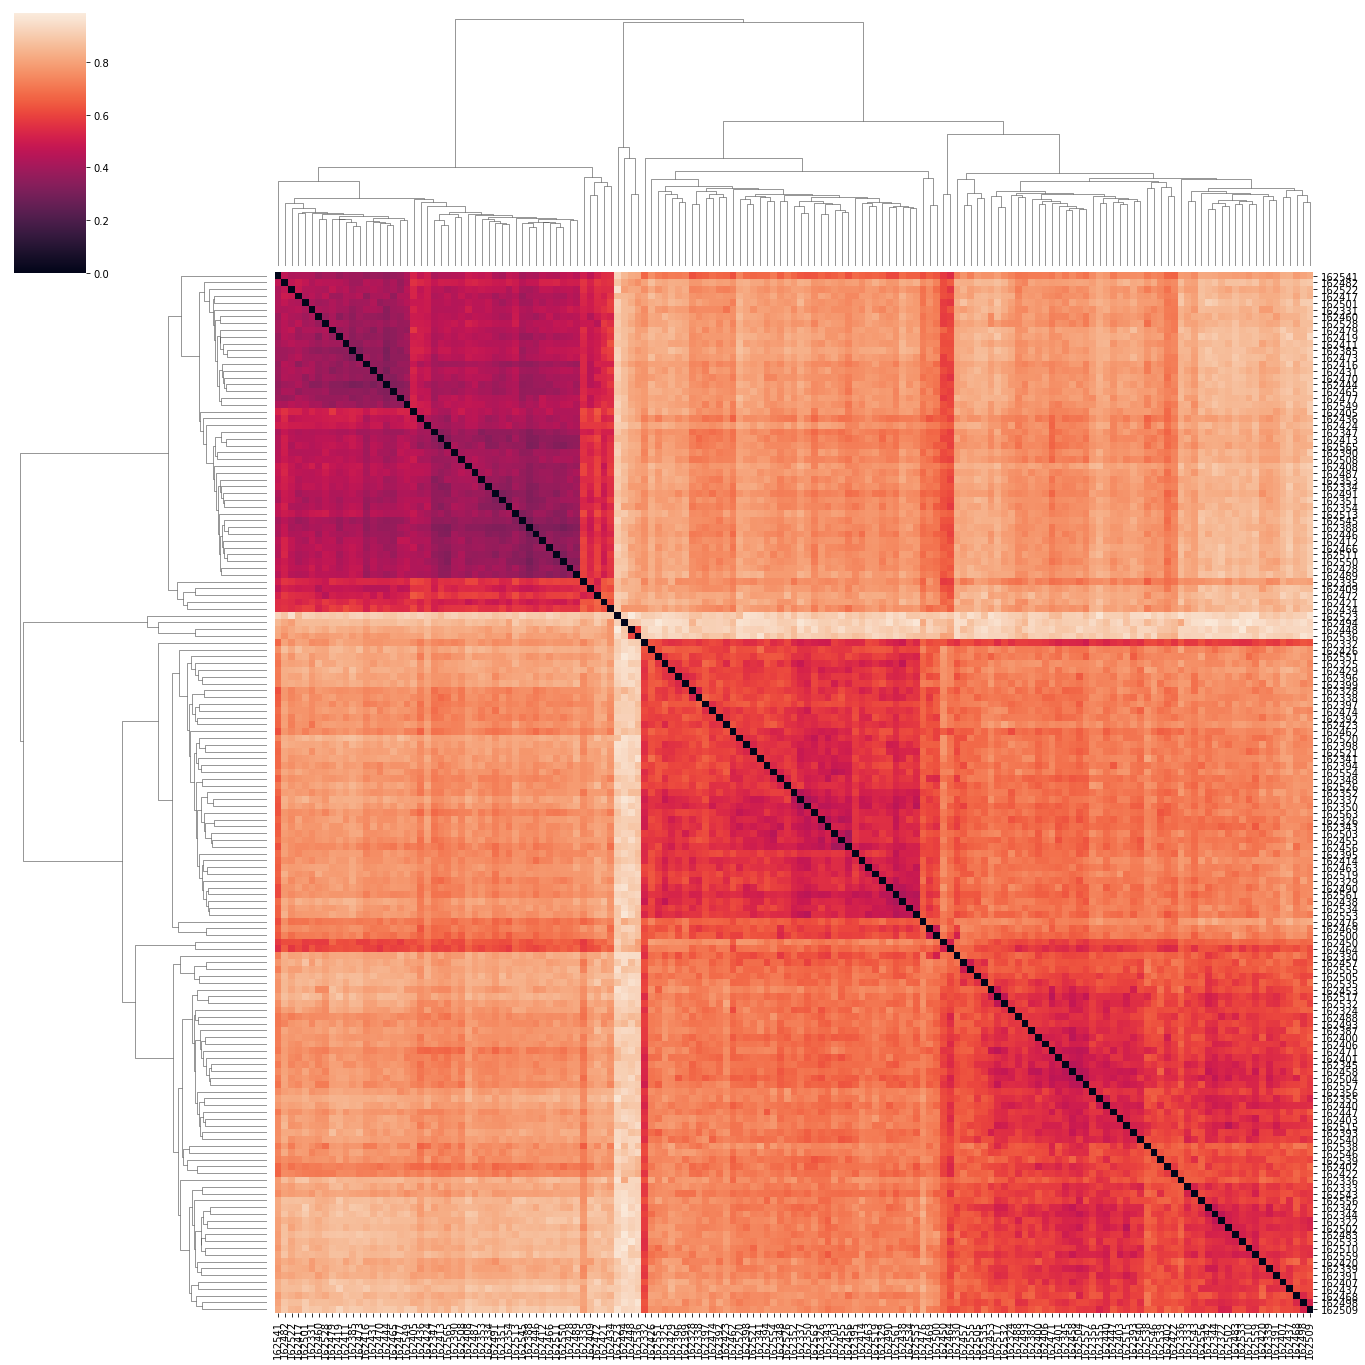

In [5]:
corr_distances = pairwise_distances(
    data.values,
    metric = 'correlation'
)
clustermap = sns.clustermap(
    corr_distances,
    xticklabels = data.index,
    yticklabels = data.index
)
clustermap.fig.set_figheight(20)
clustermap.fig.set_figwidth(20)

Correlation is a way of computing how similar the values of each feature of two data points are and it is already looking a bit more resolved so we will use this metric for clustering.

In [6]:
from sklearn.cluster import AgglomerativeClustering

# first we set up our algorithm
agg_clust = AgglomerativeClustering(
    n_clusters = 3,             # we expect 3 cluster per our inspection of the data (scatter and distance heatmap)
    affinity = 'precomputed',   # we tell the algorithm to use our precomputed pairwise distances
    linkage = 'complete'        # determines how clusters are merged
)

# computing cluster affiliation for each of our distance metrics
# and save them in a dictionary for easier retrieval later
clusterlabels = {
    key: agg_clust.fit_predict(
        distances
    ) for key, distances in zip(
        ['euclidean', 'correlation'],
        [euclid_distances, corr_distances]
    )
}

Having computed the clustering we now visualize the results as scatterplot using the same dimenionality reduction approach as before

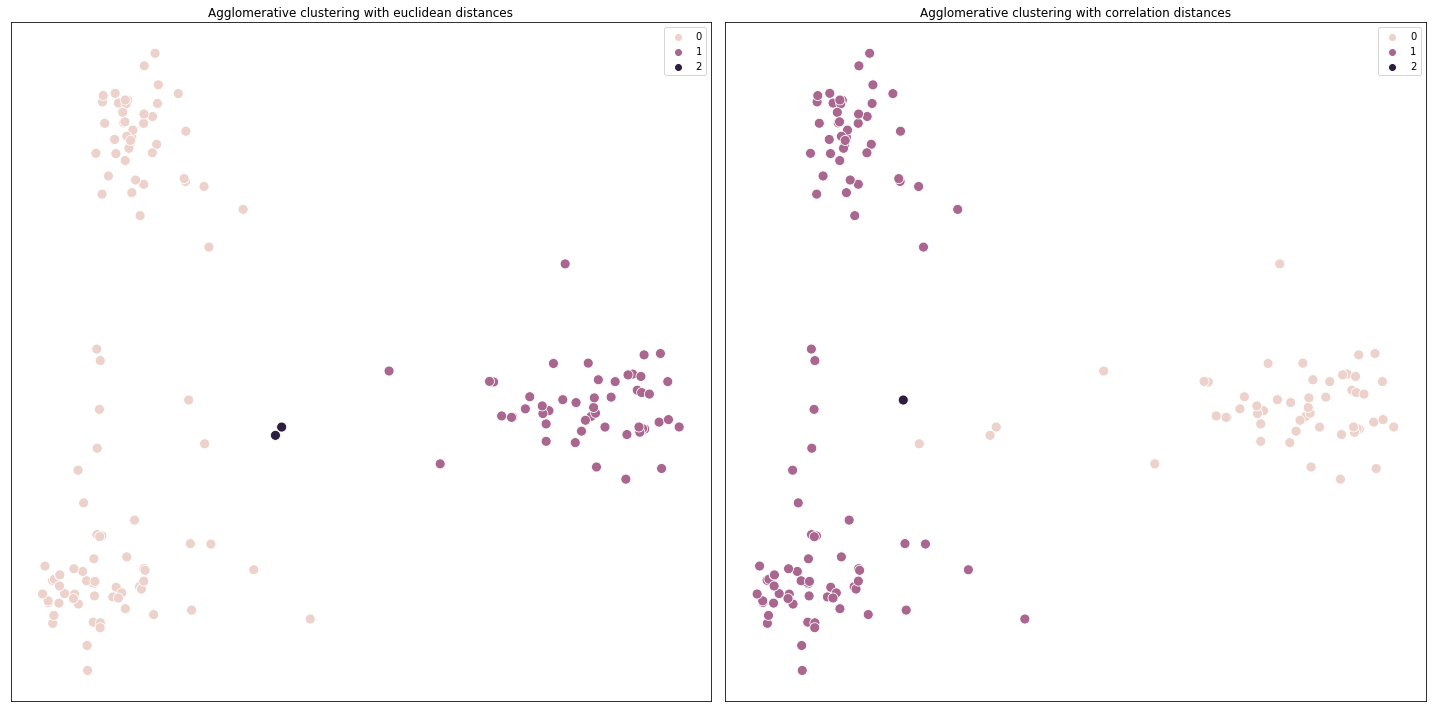

In [7]:
pca = PCA(n_components = 2)
pca_transform = pca.fit_transform(
    data.values
)

# visualize the labelling using seaborn
# which makes this much easier
fig, axs = plt.subplots(1, 2)
for (key, labels), ax in zip(clusterlabels.items(), axs):
    ax = sns.scatterplot(
        x = pca_transform[:, 0],
        y = pca_transform[:, 1],
        hue = labels,
        s = 100,
        ax = ax
    )
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_title(f'Agglomerative clustering with {key} distances')

fig.set_figheight(10)
fig.set_figwidth(20)
fig.tight_layout()

Inspecting our results we clearly see that two of our apparent clusters are merged together which is quite unsatisfying. To change this there are two possibilities, either we go back and change the parameterization of our algorithm (e.g. how many clusters we would like to find, the linkage paradigm, etc.) or we exchange the algorithm for one that is better suited (e.g. k-means). Let's try the first approach and reparameterize the algorithm and see if we can get a better result by setting a distance threshold for the linkage (i.e. if the distance/similarity exceeds a given threshold clusters are not merged anymore). We will do this for a number of values to get a better overview.

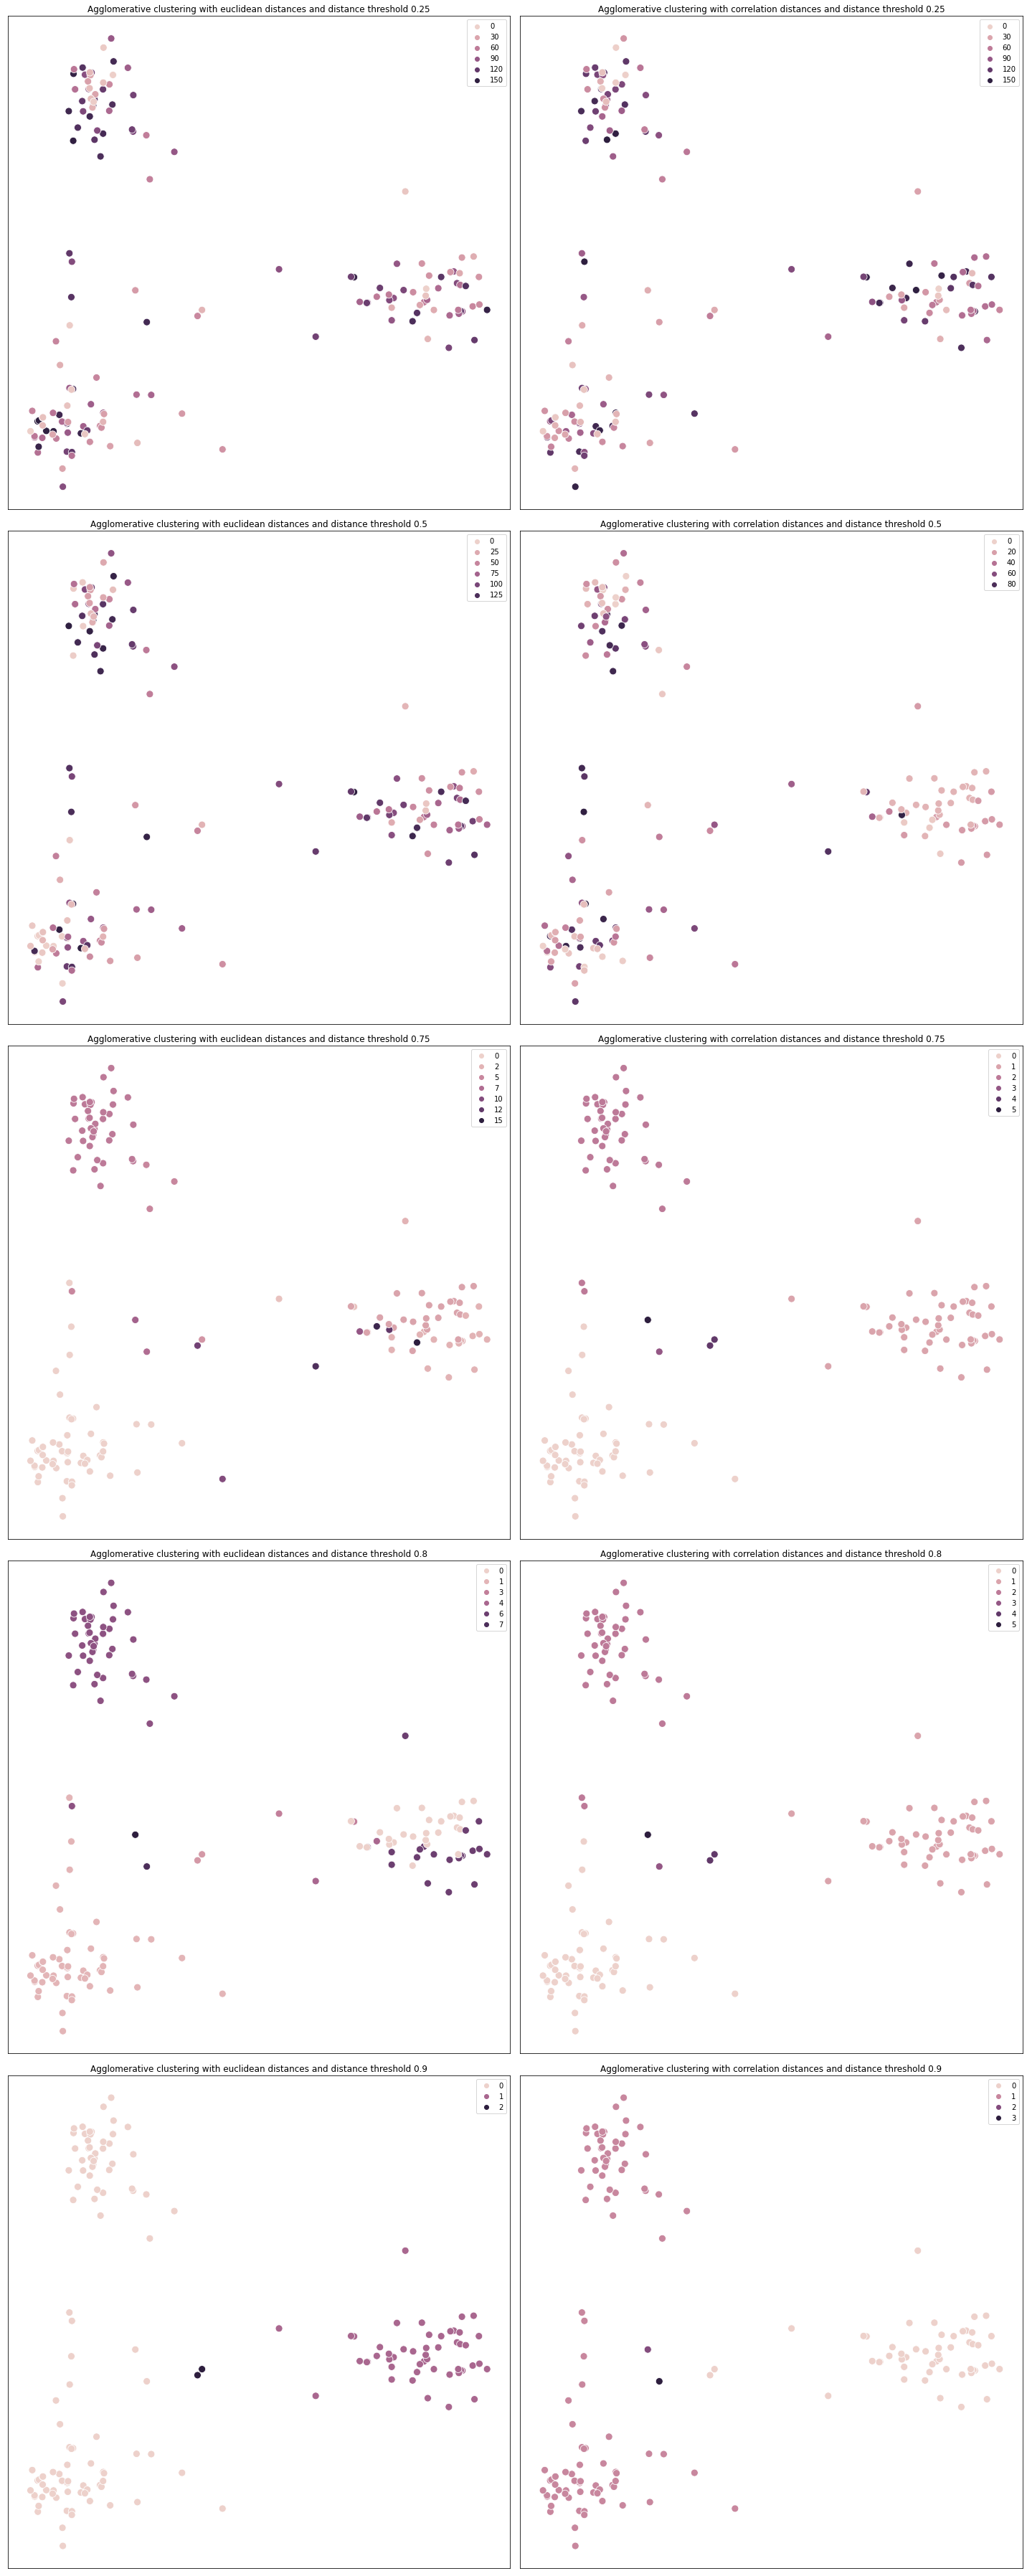

In [8]:
from sklearn.cluster import AgglomerativeClustering
import numpy as np

pca = PCA(n_components = 2)
pca_transform = pca.fit_transform(
    data.values
)

fig, meta_axs = plt.subplots(5, 2)
for threshold, axs in zip(
    [0.25, 0.5, 0.75, 0.8, 0.9],
    meta_axs
):
    # compute clustering and visualization in one go
    for key, distances, ax in zip(
        ['euclidean', 'correlation'], 
        [euclid_distances, corr_distances], 
        axs
    ):
        # setting up the algorithm again
        agg_clust = AgglomerativeClustering(
            n_clusters = None,          # needs to be None since n_clusters is now determined automatically
            affinity = 'precomputed',   # we tell the algorithm to use our precomputed pairwise distances
            linkage = 'complete',       # determines how clusters are merged
            distance_threshold = distances.max() * threshold
        )
        ax = sns.scatterplot(
            x = pca_transform[:, 0],
            y = pca_transform[:, 1],
            hue = agg_clust.fit_predict(distances),
            s = 100,
            ax = ax
        )
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_title(f'Agglomerative clustering with {key} distances and distance threshold {threshold}')

fig.set_figheight(50)
fig.set_figwidth(20)
fig.tight_layout()

Comparing the different clusterings with respect to algorithm parameterization and distance metric used, we find that using a `distance_threshold = 0.8` with complete linkage performs best based on visual inspection, despite being left with some single data point clusters (which anyway seem like outliers). Thus, we can use this clustering for further downstream analysis like differential expression analysis between clusters to infer marker genes and identify cell types. However, since this is a practical course we might as well try another algorithm just to experiment and see if it maybe performs better.

## K-means clustering
K-means is one of the most basic and well studied algorithms. Although it exists in on a spectrum of different variations that come with little improvements of its methodology the basic procedure can be summarized as follows:

1. randomly (or more sophisticated) assign each of the data points to a given cluster
2. compute the clusters center point (centroid)
3. compute distances between each data point and each clusters centroid
4. assign each data point to the cluster of the closest centroid
5. repeat 2 - 4 until cluster assignment becomes static

We will use the k-means implementation of scikit-learn to illustrate its working on our beloved single cell dataset

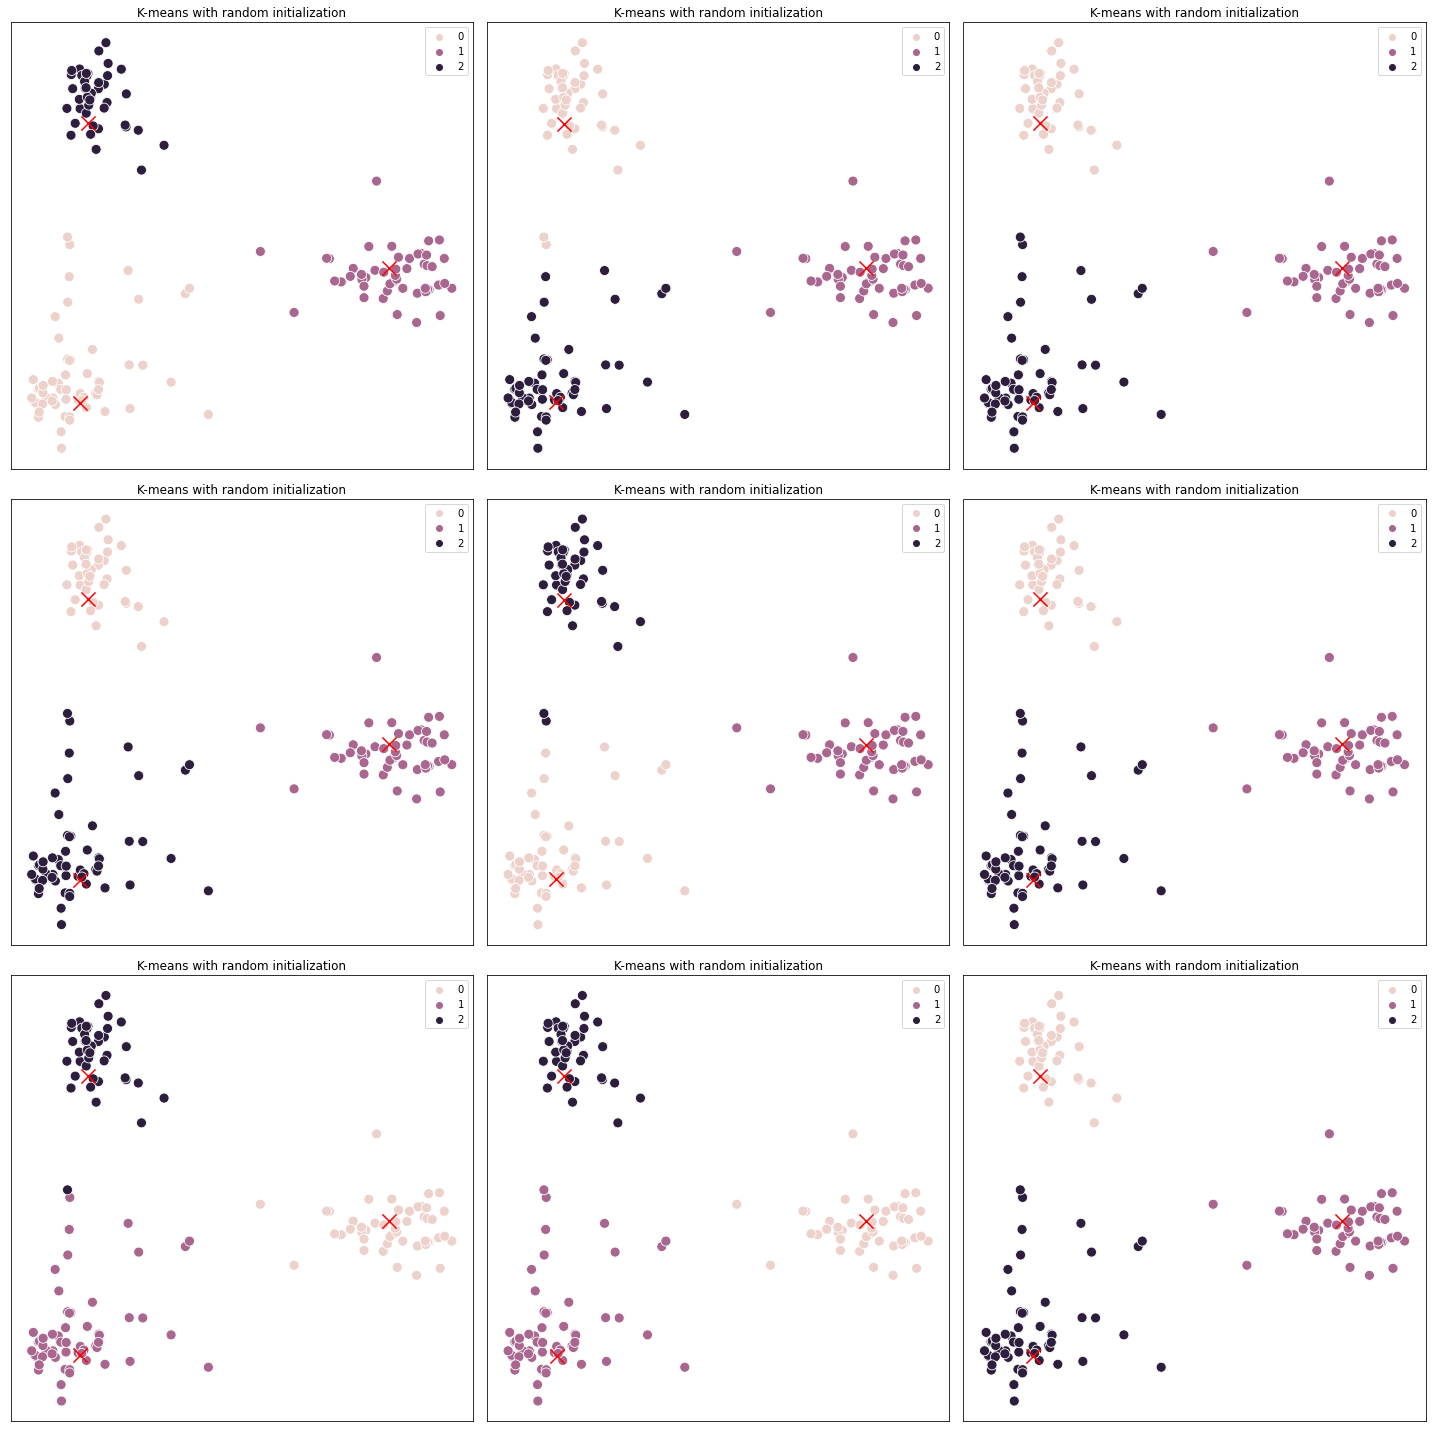

In [9]:
from sklearn.cluster import k_means

# computing kmeans clustering a few times
fig, axs = plt.subplots(3, 3)
for ax in axs.reshape(9):
    centroids, labels, _ = k_means(
        X = data.values,
        n_clusters = 3
    )

    pca = PCA(n_components = 2)
    data_transform = pca.fit_transform(
        data.values
    )
    centroid_transform = pca.fit_transform(
        centroids
    )
    
    # visualize the labelling using seaborn
    # which makes this much easier
    ax = sns.scatterplot(
        x = data_transform[:, 0],
        y = data_transform[:, 1],
        hue = labels,
        s = 100,
        ax = ax
    )
    ax.scatter(
        centroid_transform[:, 0],
        centroid_transform[:, 1],
        marker = 'x',
        s = 200,
        color = 'red'
    )
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_title(f'K-means with random initialization')

fig.set_figheight(20)
fig.set_figwidth(20)
fig.tight_layout()

As one can see, k-means performs quite good with much less overhead, which we could mainly attribute to the guassian distribution of the different features of our data points (i.e. gene expressions). However, using the default 'random' initialization of this algorithm comes with a drawback as one can see upon inspection of the above scatterplots. Each of this plots is colored based on its own k-means result and comparing either two you might notice that some points at the border between two clusters might be assigned to different clusters in two consecutive applications of the algorithm. Although, it is just one point we might get rid of this random behaviour by using a different initialization procedure or by fixing a random state such that the initializtion is always the same.

Either way, we can appreciate that k-means performs much better in this setting compared to agglomerative clustering. However, this advantage again is application based, as it might not be true for data that is far off from a normally distributed. Thus a major take home message would be to carfully evaluate the task at hand to choose the algorithms and metrics accordingly.

## Evaluating the quality of a clustering
As outlined in the preface a major goal of clustering is to find a plausible partitioning or grouping of the data. In more mathematical terms this means we want to have minimal intra-partition/group variation and maximal inter-partition/group variation (or in plain english we want the data points within a cluster to be most similar and between clusters to be most dissimliar). Therefore, a very natural way to quantify the fit of a given clustering is to compute ratios of metrics for the intra- and inter-cluster regime. Besides, this it is also possible to quantify clustering against a ground truth (e.g. you know the cell type due to some FACS data or similar). However, this approach is only rarely applicable as clustering, per definition, is used to infer groupings in data that is unlabeled.

Anyway, scikit-learn already implements the mosst used metrics for the evaluation of clustering. Here we will use the Silhouette score, which is used for unlabeled data and quantifies the goodness of fit of the clustering based on the ratio of distances between a given point and all points in its assigned cluster and its distance to all other points (see also [here](https://tushar-joshi-89.medium.com/silhouette-score-a9f7d8d78f29)) and the Rand score or Rand index, which quantifies the agreement of the found clustering to some ground truth (and thus needs some prespecified labelling).

Let's look at how this works to determine which of our previous clustering approaches worked best.

In [10]:
# get the clusterings from agglomerative and k-means clustering
# using the parameters we found previously for agglomerative
agg = AgglomerativeClustering(
    n_clusters = None,
    affinity = 'precomputed',   
    linkage = 'complete',
    distance_threshold = 0.8
)
agg_labels = agg.fit_predict(
    corr_distances
)

_, kmeans_labels, _ = k_means(
    X = data.values,
    n_clusters = 3
)

In [11]:
from sklearn.metrics import silhouette_score, rand_score
print(
    'Silhouette Score for agglomerative clustering results: %.2f' % 
    silhouette_score(
        X = corr_distances,
        metric = 'precomputed',
        labels = agg_labels
    )
)
print(
    'Silhouette Score for k-means clustering results: %.2f' %
    silhouette_score(
        X = data.values,
        metric = 'euclidean',
        labels = kmeans_labels
    )
)

Silhouette Score for agglomerative clustering results: 0.26
Silhouette Score for k-means clustering results: 0.12


We see that the silhouette score for agglomerative clustering is much higher than that of k-means. However, this is an unfair comparison as we are using different distance metrics for the two. Let's see what happens if we use the same metric.

In [12]:
for X, metric in zip(
    [data.values, corr_distances], 
    ['euclidean', 'precomputed']
):
    for labels, method in zip(
        [agg_labels, kmeans_labels],
        ['agglomerative', 'k-means']
    ):
        print(
            'Silhouette Score for %s clustering results using %s: %.2f' % 
            (
                method,
                metric,
                silhouette_score(
                    X = X,
                    metric = metric,
                    labels = labels
                )
            )
        )

Silhouette Score for agglomerative clustering results using euclidean: 0.12
Silhouette Score for k-means clustering results using euclidean: 0.12
Silhouette Score for agglomerative clustering results using precomputed: 0.26
Silhouette Score for k-means clustering results using precomputed: 0.25


Comparing the results based on the same distance metric makes them almost indistinguishable, which boils the decision down to practical aspects of the task which is ease of use where k-means is a clear winner as judged by the amount of code needed to get it going. However, let's also have a look at the Rand score of the results. For this, we first need to load the ground truth, that is the actual cell type assignment, which we have precomputed for you.

In [13]:
true_labels = pd.read_csv(
    'data/scRNAseq_celltype.tsv',
    index_col = 0
)
true_labels

,cell_type
sample_id,
162322,olfactory_cells
162324,olfactory_cells
162325,neurons
162326,neurons
162328,neurons
...,...
162557,olfactory_cells
162559,olfactory_cells
162561,neurons


In [14]:
# utility function to find correspondence between true and predicted labels
def get_label_correspondence(true_labels, pred_labels):
    df = pd.DataFrame(
        {
            'true_labels': true_labels,
            'pred_labels': pred_labels
        }
    )
    aggregation = df \
        .groupby('true_labels') \
        .apply(np.unique, return_counts = True)

    label_assignment = {
        true_label: pred_labels[np.argmax(counts)]
        for true_label, (pred_labels, counts) in aggregation.items()
    }
    correspondence = df.true_labels.apply(
        lambda x: label_assignment[x]
    )
    return correspondence.values
        
    
for method, labels_pred in zip(
    ['agglomerative', 'k-means'],
    [agg_labels, kmeans_labels]
):
    labels_true = get_label_correspondence(
        true_labels.cell_type.values,
        labels_pred
    )
    print(
        'Rand score for %s clustering: %.2f' %
        (method, rand_score(labels_true, labels_pred))
    )

Rand score for agglomerative clustering: 0.98
Rand score for k-means clustering: 0.98


The Rand score indicates a slight edge for the k-means clustering. Compiling the evidence we gathered through trial and error, we find that k-means clustering is the best algorithm for the task at hand (chosing from only the two algorithms we used here)